# CRNN-CTC È™åËØÅÁ†ÅËØÜÂà´

üòãüòãÂÖ¨‰ºóÂè∑ÁÆóÊ≥ïÁæéÈ£üÂ±ãÂêéÂè∞ÂõûÂ§çÂÖ≥ÈîÆËØçÔºö**torchkeras**ÔºåËé∑ÂèñÊú¨ÊñánotebookÊ∫ê‰ª£Á†ÅÂíåÊï∞ÊçÆÈõÜ‰∏ãËΩΩÈìæÊé•„ÄÇ

Êú¨ËåÉ‰æãÊàë‰ª¨‰ΩøÁî®ÁªèÂÖ∏ÁöÑ CRNN+ CTC Loss ÁöÑOCRÊ®°ÂûãÊù•ËØÜÂà´È™åËØÅÁ†Å„ÄÇ

Êàë‰ª¨ÈÄöËøáÂØºÂÖ•‰∏Ä‰∏™Âè´ [captcha](https://github.com/lepture/captcha/) ÁöÑÂ∫ìÊù•ÁîüÊàêÈ™åËØÅÁ†Å„ÄÇ

Êàë‰ª¨ÁîüÊàêÈ™åËØÅÁ†ÅÁöÑÂ≠óÁ¨¶Áî±Êï∞Â≠óÂíåÂ§ßÂÜôÂ≠óÊØçÁªÑÊàê„ÄÇ

È°πÁõÆÂèÇËÄÉÔºö https://github.com/ypwhs/captcha_break 



In [ ]:
#!pip install captcha torchkeras 

In [1]:
import torch 
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchvision.transforms.functional import to_tensor, to_pil_image

from tqdm import tqdm
import random
import numpy as np

import torchkeras 
from pathlib import Path
from collections import OrderedDict 


characters = '-' + '0123456789ABCDEFGHIJKLMNOPQRSTUVWXYZ'  # Ê≥®Ôºö‚Äô-‚Äò ‰∏∫[blank] ÁâπÊÆäÂ≠óÁ¨¶
width, height  = 192, 64
n_classes = len(characters)

txt_length = 4 #ËØÜÂà´ÁöÑÈ™åËØÅÁ†ÅÈïøÂ∫¶
seq_length = 12 #CRNNËæìÂá∫Â∫èÂàóÈïøÂ∫¶Ôºå‰∏ÄËà¨Ë¶ÅÊ±Ç seq_length>=2*txt_length+1 


## ‰∏ÄÔºåÂáÜÂ§áÊï∞ÊçÆ

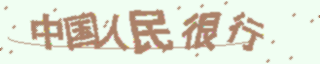

In [2]:
from captcha.image import ImageCaptcha
generator = ImageCaptcha(width=320, height=64, 
        fonts=[str(Path(torchkeras.__file__).parent/'assets'/'SimHei.ttf') ],
        font_sizes=[40,45])
generator.generate_image('‰∏≠ÂõΩ‰∫∫Ê∞ëÂæàË°å')



In [3]:
class CaptchaDataset(Dataset):
    def __init__(self, characters, length, 
                 width, height, input_length, label_length):
        super(CaptchaDataset, self).__init__()
        self.characters = characters
        self.length = length
        self.width = width
        self.height = height
        self.input_length = input_length
        self.label_length = label_length
        self.n_class = len(characters)
        self.generator = ImageCaptcha(width=width, height=height)

    def __len__(self):
        return self.length
    
    def __getitem__(self, index):
        random_str = ''.join([random.choice(self.characters[1:]) for j in range(self.label_length)])
        image = to_tensor(self.generator.generate_image(random_str))
        target = torch.tensor([self.characters.find(x) for x in random_str], dtype=torch.long)
        input_length = torch.full(size=(1, ), fill_value=self.input_length, dtype=torch.long)
        target_length = torch.full(size=(1, ), fill_value=self.label_length, dtype=torch.long)
        return image, target, input_length, target_length
    
    

SUKD tensor([12]) tensor([4])


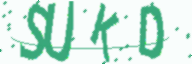

In [4]:
batch_size = 128
ds_train= CaptchaDataset(characters, 100 * batch_size, 
                         width, height, seq_length, txt_length)

ds_val = CaptchaDataset(characters, 20 * batch_size, 
                        width, height, seq_length, txt_length)

dl_train = DataLoader(ds_train, batch_size=batch_size, num_workers=0)
dl_val = DataLoader(ds_val, batch_size=batch_size, num_workers=0)

ds_test = CaptchaDataset(characters, 1, width, height, seq_length, txt_length)

image, target, input_length, label_length = ds_test[0]
print(''.join([characters[x] for x in target]), input_length, label_length)
to_pil_image(image)


##  ‰∫åÔºåÂÆö‰πâÊ®°Âûã

In [5]:
class CRNN(nn.Module):
    def __init__(self, n_classes, input_shape=(3, 64, 128)):
        super().__init__()
        self.input_shape = input_shape
        channels = [32, 64, 128, 256, 256]
        layers = [2, 2, 2, 2, 2]
        kernels = [3, 3, 3, 3, 3]
        pools = [2, 2, 2, 2, (2, 1)]
        modules = OrderedDict()
        
        def cba(name, in_channels, out_channels, kernel_size):
            modules[f'conv{name}'] = nn.Conv2d(in_channels, out_channels, kernel_size,
                                               padding=(1, 1) if kernel_size == 3 else 0)
            modules[f'bn{name}'] = nn.BatchNorm2d(out_channels)
            modules[f'relu{name}'] = nn.ReLU(inplace=True)
        
        last_channel = 3
        for block, (n_channel, n_layer, n_kernel, k_pool) in enumerate(zip(channels, layers, kernels, pools)):
            for layer in range(1, n_layer + 1):
                cba(f'{block+1}{layer}', last_channel, n_channel, n_kernel)
                last_channel = n_channel
            modules[f'pool{block + 1}'] = nn.MaxPool2d(k_pool)
        modules[f'dropout'] = nn.Dropout(0.25, inplace=True)
        
        self.cnn = nn.Sequential(modules)
        self.lstm = nn.LSTM(input_size=self.infer_features(), hidden_size=128, num_layers=2, bidirectional=True)
        self.fc = nn.Linear(in_features=256, out_features=n_classes)
    
    def infer_features(self):
        x = torch.zeros((1,)+self.input_shape)
        x = self.cnn(x)
        x = x.reshape(x.shape[0], -1, x.shape[-1])
        return x.shape[1]
    

    def forward(self, x):
        x = self.cnn(x)
        x = x.reshape(x.shape[0], -1, x.shape[-1])
        x = x.permute(2, 0, 1)
        x, _ = self.lstm(x)
        x = self.fc(x)
        return x
    

In [6]:
net = CRNN(n_classes, input_shape=(3, height, width))
inputs = torch.zeros((32, 3, height, width))
outputs = net(inputs)
print(outputs.shape) # LSTMÈªòËÆ§ËæìÂá∫ÁöÑÂΩ¢Áä∂ÊòØ LengthÂú®Ââç
#net.cuda();


torch.Size([12, 32, 37])


## ‰∏âÔºå ËÆ≠ÁªÉÊ®°Âûã

In [7]:
# Ëß£Á†ÅÂáΩÊï∞ÂíåËÆ°ÁÆóÂáÜÁ°ÆÁéáÂáΩÊï∞

def decode_target(sequence):
    return ''.join([characters[x] for x in sequence]).replace(' ', '')

def decode(sequence):
    a = ''.join([characters[x] for x in sequence])
    s = ''.join([x for j, x in enumerate(a[:-1]) if x != characters[0] and x != a[j+1]])
    if len(s) == 0:
        return ''
    if a[-1] != characters[0] and s[-1] != a[-1]:
        s += a[-1]
    return s


def eval_acc(targets, preds):
    preds_argmax = preds.detach().permute(1, 0, 2).argmax(dim=-1)
    targets = targets.cpu().numpy()
    preds_argmax = preds_argmax.cpu().numpy()
    a = np.array([decode_target(gt) == decode(pred) for gt,
                  pred in zip(targets, preds_argmax)])
    return a.mean()



In [8]:
import torch.nn.functional as F 
from torchkeras import KerasModel

#Êàë‰ª¨Ë¶ÜÁõñKerasModelÁöÑStepRunner‰ª•ÂÆûÁé∞Ëá™ÂÆö‰πâËÆ≠ÁªÉÈÄªËæë„ÄÇ
#Ê≥®ÊÑèËøôÈáåÊääaccÊåáÊ†áÁöÑÁªìÊûúÂÜôÂú®‰∫Üstep_loss‰∏≠‰ª•‰æøÂíåloss‰∏ÄÊ†∑Âú®Epoch‰∏äÊ±ÇÂπ≥ÂùáÔºåËøôÊòØ‰∏Ä‰∏™ÈùûÂ∏∏ÁÅµÊ¥ªËÄå‰∏îÊúâÁî®ÁöÑÂÜôÊ≥ï„ÄÇ

class StepRunner:
    def __init__(self, net, loss_fn, accelerator, stage = "train", metrics_dict = None, 
                 optimizer = None, lr_scheduler = None
                 ):
        self.net,self.loss_fn,self.metrics_dict,self.stage = net,loss_fn,metrics_dict,stage
        self.optimizer,self.lr_scheduler = optimizer,lr_scheduler
        self.accelerator = accelerator
        if self.stage=='train':
            self.net.train() 
        else:
            self.net.eval()
    
    def __call__(self, batch):
        
        images, targets, input_lengths, target_lengths = batch
        
        #loss
        preds = self.net(images)
        preds_log_softmax = F.log_softmax(preds, dim=-1)
        loss = F.ctc_loss(preds_log_softmax, targets, input_lengths, target_lengths)
        acc = eval_acc(targets,preds)
            

        #backward()
        if self.optimizer is not None and self.stage=="train":
            self.accelerator.backward(loss)
            self.optimizer.step()
            if self.lr_scheduler is not None:
                self.lr_scheduler.step()
            self.optimizer.zero_grad()
            
            
        all_loss = self.accelerator.gather(loss).sum()
        
        #losses
        step_losses = {self.stage+"_loss":
                       all_loss.item(),
                       self.stage+'_acc':acc}
        
        #metrics
        step_metrics = {}
        if self.stage=="train":
            if self.optimizer is not None:
                step_metrics['lr'] = self.optimizer.state_dict()['param_groups'][0]['lr']
            else:
                step_metrics['lr'] = 0.0
        return step_losses,step_metrics
    
    
KerasModel.StepRunner = StepRunner 



In [9]:
model = KerasModel(net,
                   loss_fn=None,
                   optimizer = torch.optim.AdamW(net.parameters(),lr = 2e-6)
                   )

#model.load_ckpt('ctc_crnn.pt')


<<<<<< üêå cpu is used >>>>>>


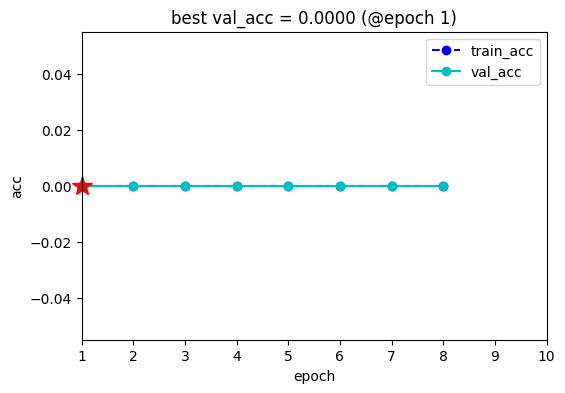

In [ ]:
model.fit(
    train_data = dl_train,
    val_data= dl_val,
    ckpt_path='ctc_crnn.pt',
    epochs=30,
    patience=10,
    monitor="val_acc", 
    mode="max",
    plot = True,
    wandb = False,
    callbacks=[visdis],
    cpu=True
)

## ÂõõÔºåËØÑ‰º∞Ê®°Âûã

In [11]:
def display_fn(model):
    model.eval()
    right = True
    while right:
        image, target, input_length, label_length = ds_test[0]
        output = model(image.unsqueeze(0))
        output_argmax = output.detach().permute(1, 0, 2).argmax(dim=-1)
        right = (decode_target(target) == decode(output_argmax[0]))
        print('gt:', decode_target(target),' ','pred:', decode(output_argmax[0]))
    display(to_pil_image(image))
    
    
from torchkeras.kerascallbacks import VisDisplay
visdis = VisDisplay(display_fn,model)


Output()

## ‰∫îÔºå‰ΩøÁî®Ê®°Âûã


In [22]:
def predict(model,image):
    model.cuda()
    tensor = to_tensor(image)
    output = model(tensor.unsqueeze(0).cuda())
    output_argmax = output.detach().permute(1, 0, 2).argmax(dim=-1)
    preds = decode(output_argmax[0])
    return preds

In [21]:
model.load_ckpt('ctc_crnn.pt')

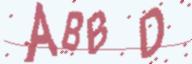

'ABBD'

In [39]:
generator = ImageCaptcha(width=width, height=height)
image = generator.generate_image('ABBD')
display(image)
predict(model,image)

## ÂÖ≠Ôºå‰øùÂ≠òÊ®°Âûã

In [32]:
torch.save(model.net.state_dict(),'best.pt')

**Â¶ÇÊûúÊú¨È°πÁõÆÂØπ‰Ω†ÊúâÊâÄÂ∏ÆÂä©ÔºåÊÉ≥ÈºìÂä±‰∏Ä‰∏ã‰ΩúËÄÖÔºåËÆ∞ÂæóÁªôÊú¨È°πÁõÆÂä†‰∏ÄÈ¢óÊòüÊòüstar‚≠êÔ∏èÔºåÂπ∂ÂàÜ‰∫´Áªô‰Ω†ÁöÑÊúãÂèã‰ª¨Âñîüòä!** 

Â¶ÇÊûúÂú®torchkerasÁöÑ‰ΩøÁî®‰∏≠ÈÅáÂà∞ÈóÆÈ¢òÔºåÂèØ‰ª•Âú®È°πÁõÆ‰∏≠Êèê‰∫§issue„ÄÇ

Â¶ÇÊûúÊÉ≥Ë¶ÅËé∑ÂæóÊõ¥Âø´ÁöÑÂèçÈ¶àÊàñËÄÖ‰∏éÂÖ∂‰ªñtorchkerasÁî®Êà∑Â∞è‰ºô‰º¥ËøõË°å‰∫§ÊµÅÔºå

ÂèØ‰ª•Âú®ÂÖ¨‰ºóÂè∑ÁÆóÊ≥ïÁæéÈ£üÂ±ãÂêéÂè∞ÂõûÂ§çÂÖ≥ÈîÆÂ≠óÔºö**Âä†Áæ§**„ÄÇ

![](https://tva1.sinaimg.cn/large/e6c9d24egy1h41m2zugguj20k00b9q46.jpg)